<a href="https://colab.research.google.com/github/davidandw190/faas-dl-inference/blob/main/notebooks/face_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Face Emotion Detection

In [ ]:
!pip install onnxruntime numpy pillow

In [ ]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
model_path = "emotion-ferplus-8.onnx"

try:
    session = ort.InferenceSession(model_path)
    print("Emotion recognition model loaded successfully.")
except Exception as e:
    print(f"Error loading the emotion recognition model: {str(e)}")
    raise

emotion_table = {0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness',
                 4: 'anger', 5: 'disgust', 6: 'fear', 7: 'contempt'}

In [ ]:
def preprocess(image_path):
    input_shape = (1, 1, 64, 64)
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((64, 64), Image.LANCZOS)
    img_data = np.array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = np.expand_dims(img_data, axis=0)
    return img_data.astype(np.float32)

In [ ]:
def softmax(scores):
    exp = np.exp(scores - np.max(scores))
    return exp / exp.sum()

In [ ]:
def predict_emotion(image_path):
    input_data = preprocess(image_path)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name

    scores = session.run([output_name], {input_name: input_data})[0]
    probabilities = softmax(scores[0])

    emotion_index = np.argmax(probabilities)
    emotion = emotion_table[emotion_index]
    confidence = probabilities[emotion_index]

    return emotion, confidence, probabilities

In [ ]:
def process_image(image_path, title):
    emotion, confidence, probabilities = predict_emotion(image_path)

    img = Image.open(image_path)
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{title}\nPredicted Emotion: {emotion}\nConfidence: {confidence:.2f}")

    plt.subplot(1, 2, 2)
    bars = plt.bar(emotion_table.values(), probabilities)
    plt.title("Emotion Probabilities")
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [ ]:
def test_on_sample_images(image_directory):
    if not os.path.exists(image_directory):
        print(f"Error: Directory {image_directory} does not exist.")
        return

    for filename in os.listdir(image_directory):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_directory, filename)
            print(f"\nProcessing image: {filename}")
            process_image(image_path, filename)

Emotion recognition model loaded successfully.

Testing emotion recognition on sample images:

Processing image: very_old_man_face.jpg


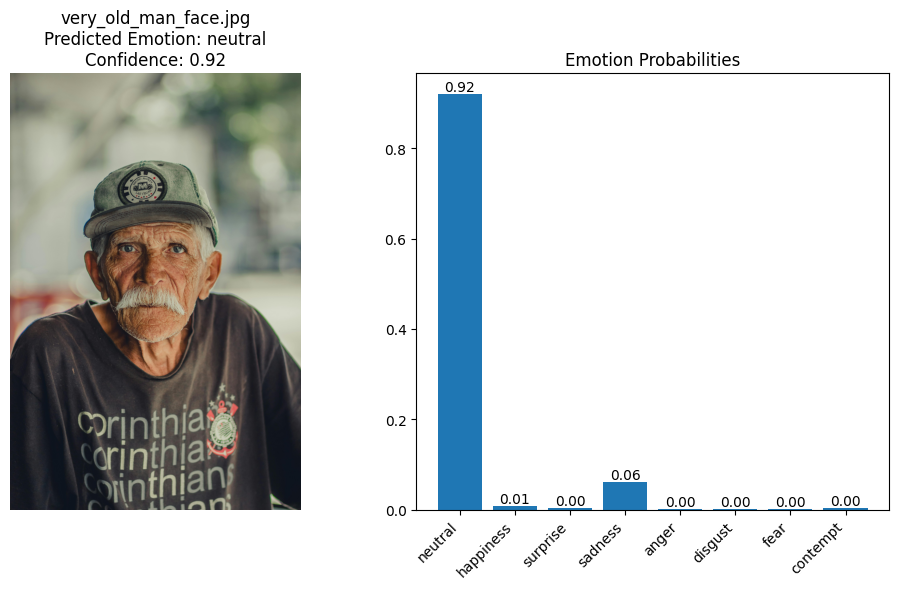


Processing image: old_man_face.jpg


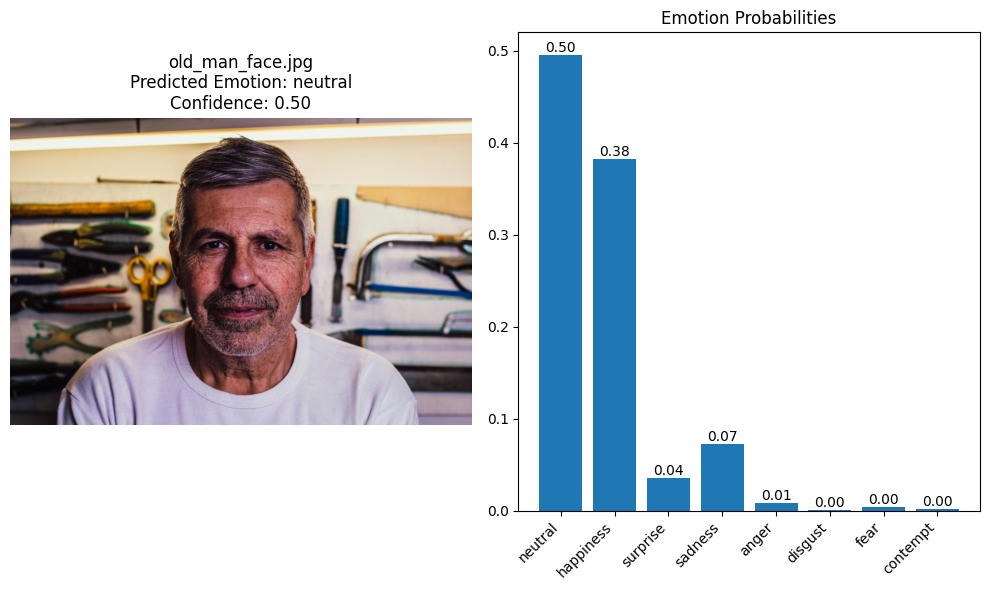


Processing image: single_face.jpg


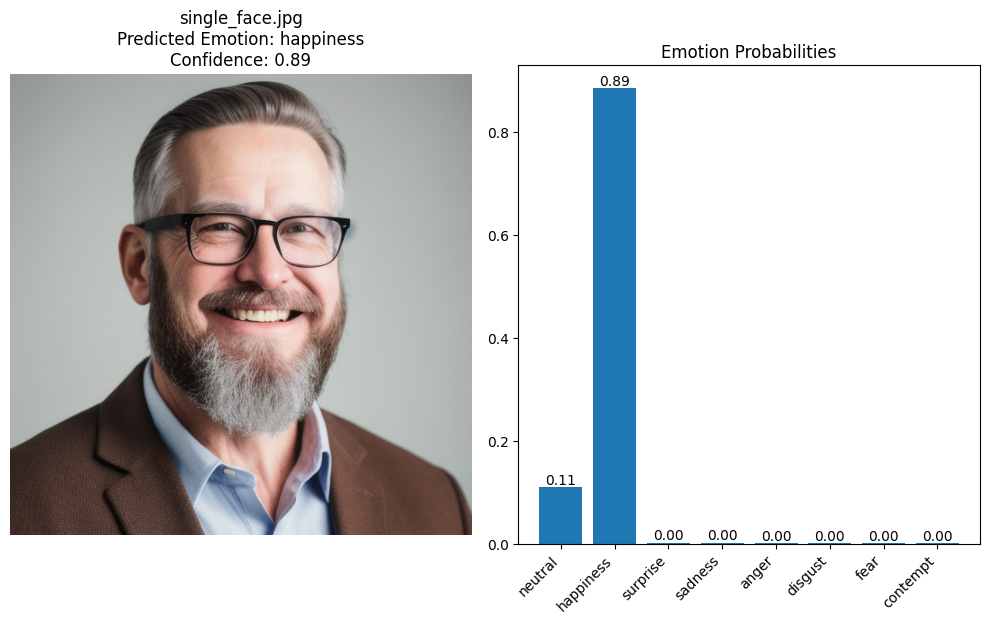


Processing image: crying_man_face.jpg


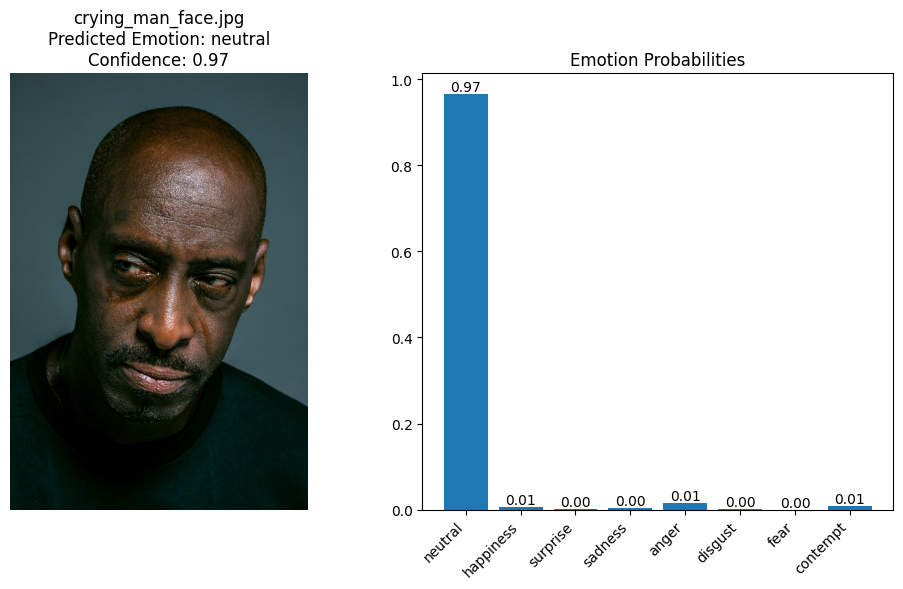


Processing image: dissapointed_kid_face.jpg


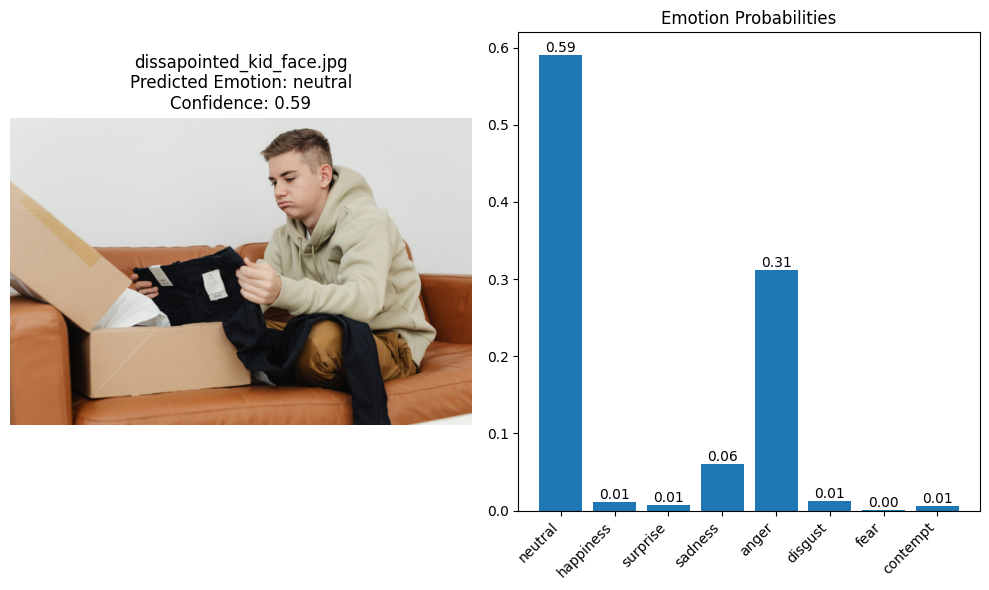


Processing image: woman_face.jpg


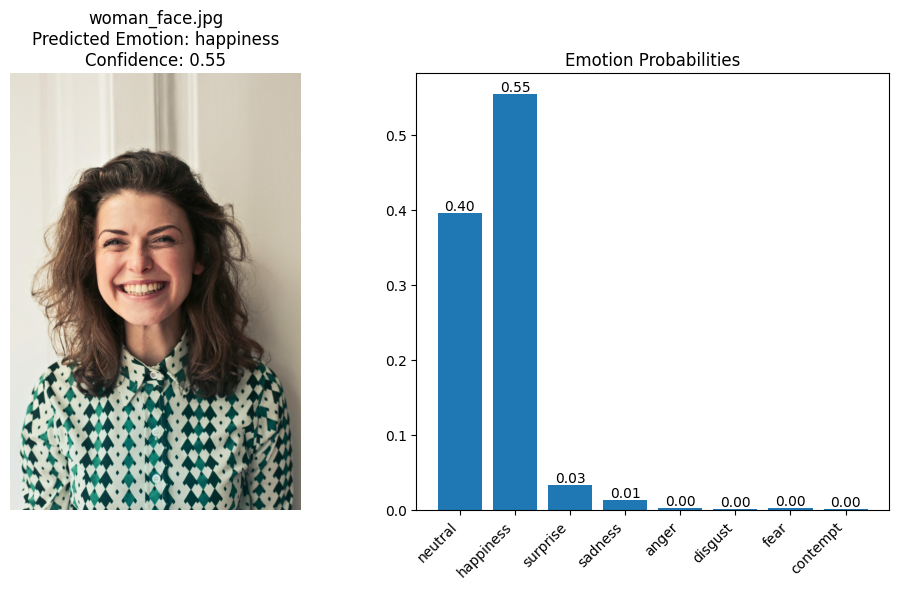


Processing image: surprised_man_face.jpg


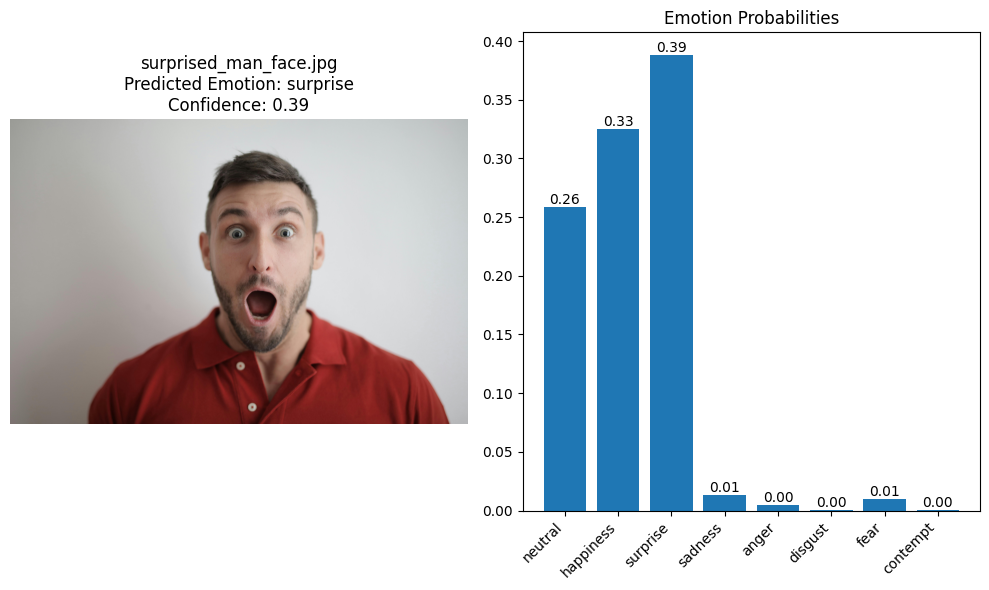

In [16]:
test_image_directory = "test_images"

if not os.path.exists(test_image_directory):
    os.makedirs(test_image_directory)
    print(f"Created directory: {test_image_directory}")

print("\nTesting emotion recognition on sample images:")
test_on_sample_images(test_image_directory)